# Result Analysis

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
from scipy import stats

import pandas as pd
import pickle
import torch
from itertools import combinations
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir'),
 'figdir': PosixPath('../data/results/figures'),
 'resultdir': PosixPath('../data/results'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime',
  'chartinterval'],
 'dates': ['charttime', 'intime'],
 'ia_thresh': {'lr': 0.45, 'rf': 0.27, 'gbm': 0.435, 'mlp': 0.2},
 'ps_thresh': {'lr': 0.39, 'rf': 0.36, 'gbm': 0.324, 'mlp': 0.27}}

## Compute Results

In [3]:
models = ['lr', 'rf', 'gbm', 'mlp']

ia_bams = {}
ps_bams = {}

for model in models:
  with open(args.workdir/model/'imminent_adm_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
  ia_bams[model] = BinaryAvgMetrics(targs, preds, probs)
    
  with open(args.workdir/model/'prolonged_stay_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)    
  ps_bams[model] = BinaryAvgMetrics(targs, preds, probs)    

### Ensemble

In [4]:
def get_ensemble(ensembles, thresh, bams):  
  outputs = {}
  for ens_model in ensembles:
    key = '-'.join(ens_model)
    targs = bams[ens_model[0]].targs
    avg_thresh = np.array([thresh[model] for model in ens_model]).mean()
    max_thresh = max([thresh[model] for model in ens_model])
    probs = []
    for i in range(len(targs)):
      prob = []
      for model in ens_model:
        prob.append(bams[model].probs[i])
      probs.append(np.stack(prob))

    avg_probs = [probs.mean(axis=0) for probs in probs]
    max_probs = [probs.max(axis=0) for probs in probs]

    avg_preds = [(probs > avg_thresh).astype(np.int64) for probs in avg_probs]
    max_preds = [(probs > max_thresh).astype(np.int64) for probs in max_probs]
    outputs[f'avg-{key}'] = (targs, avg_preds, avg_probs, avg_thresh)
    outputs[f'max-{key}'] = (targs, max_preds, max_probs, max_thresh)
    
  return outputs

In [5]:
ensembles = [
  ['gbm', 'mlp'],
  ['rf', 'mlp'],
  ['rf', 'gbm'],
  ['rf', 'gbm', 'mlp'],
  ['lr', 'mlp'],
  ['lr', 'gbm'],
  ['lr', 'gbm', 'mlp'],
  ['lr', 'rf'],
  ['lr', 'rf', 'mlp'],
  ['lr', 'rf', 'gbm'],
  ['lr', 'rf', 'gbm', 'mlp']
]

In [6]:
ia_ensembles = get_ensemble(ensembles, args.ia_thresh, ia_bams)

for model, vals in ia_ensembles.items():
  args.ia_thresh[model] = np.round(vals[-1], 3)

for model, vals in ia_ensembles.items():
  ia_bams[model] = BinaryAvgMetrics(*vals[:-1])  

ps_ensembles = get_ensemble(ensembles, args.ps_thresh, ps_bams)

for model, vals in ps_ensembles.items():
  args.ps_thresh[model] = np.round(vals[-1], 3)

for model, vals in ps_ensembles.items():
  ps_bams[model] = BinaryAvgMetrics(*vals[:-1])  

### Compute Results DataFrame

In [7]:
ia_metrics = {}
ps_metrics = {}

for key in ia_bams.keys():
  ia_metrics[key] = []
  ps_metrics[key] = []
  for i in range(len(ia_bams[key].get_avg_metrics())):
    ia_metrics[key].append(ia_bams[key].get_avg_metrics().iloc[i]['Value'])
  for i in range(len(ps_bams[key].get_avg_metrics())):
    ps_metrics[key].append(ps_bams[key].get_avg_metrics().iloc[i]['Value'])    

ia_metrics = pd.DataFrame(ia_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1']).transpose()
ps_metrics = pd.DataFrame(ps_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1']).transpose()

In [8]:
ia_best = pd.DataFrame([(ia_metrics[metric].idxmax(), ia_metrics[metric].max()) for metric in ia_metrics], columns=['model', 'value'], index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
ps_best = pd.DataFrame([(ps_metrics[metric].idxmax(), ps_metrics[metric].max()) for metric in ps_metrics], columns=['model', 'value'], index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])

### Student-t Tests

In [9]:
models = list(ia_metrics.index)
metrics = list(ia_metrics.columns)

In [10]:
def do_ttest(bams, model1, model2, metric):  
  if metric == 'sensitivity':
    x1 = bams[model1].sensitivities()
    x2 = bams[model2].sensitivities()
  elif metric == 'specificity':
    x1 = bams[model1].specificities()
    x2 = bams[model2].specificities()
  elif metric == 'ppv':
    x1 = bams[model1].ppvs()
    x2 = bams[model2].ppvs()
  elif metric == 'auroc':
    x1 = bams[model1].aurocs()
    x2 = bams[model2].aurocs()
  elif metric == 'npv':
    x1 = bams[model1].npvs()
    x2 = bams[model2].npvs()
  elif metric == 'f1':    
    x1 = bams[model1].f1s()
    x2 = bams[model2].f1s()

  t, p = stats.ttest_ind(x1, x2)
  return np.round(t, 2), max(np.round(p, 2), 0.001)

In [11]:
ia_ttests = {}

for m1, m2 in combinations(models, 2):  
  ia_ttests[f'{m1}:{m2}'] = {}
  for metric in metrics:
    ia_ttests[f'{m1}:{m2}'][metric] = do_ttest(ia_bams, m1, m2, metric)

ia_ttests = pd.DataFrame(ia_ttests).transpose()

In [12]:
ps_ttests = {}

for m1, m2 in combinations(models, 2):  
  ps_ttests[f'{m1}:{m2}'] = {}
  for metric in metrics:
    ps_ttests[f'{m1}:{m2}'][metric] = do_ttest(ps_bams, m1, m2, metric)

ps_ttests = pd.DataFrame(ps_ttests).transpose()

### Write everything to disk

In [13]:
with open(args.resultdir/'bams.pkl', 'wb') as f:
  pickle.dump(ia_bams, f)
  pickle.dump(ps_bams, f)

ia_metrics.to_csv(args.resultdir/'ia_metrics.csv', float_format='%.1f')
ps_metrics.to_csv(args.resultdir/'ps_metrics.csv', float_format='%.1f')
ia_best.to_csv(args.resultdir/'ia_best.csv', float_format='%.3f')
ps_best.to_csv(args.resultdir/'ps_best.csv', float_format='%.3f')

ia_ttests.to_csv(args.resultdir/'ia_ttests.csv')
ps_ttests.to_csv(args.resultdir/'ps_ttests.csv')

## 100 Iteration Results

In [3]:
with open(args.resultdir/'bams.pkl', 'rb') as f:
  ia_bams = pickle.load(f)
  ps_bams = pickle.load(f)
  
ia_metrics = pd.read_csv(args.resultdir/'ia_metrics.csv', index_col=0)
ps_metrics = pd.read_csv(args.resultdir/'ps_metrics.csv', index_col=0)
ia_best = pd.read_csv(args.resultdir/'ia_best.csv', index_col=0)
ps_best = pd.read_csv(args.resultdir/'ps_best.csv', index_col=0)

ia_ttests = pd.read_csv(args.resultdir/'ia_ttests.csv', index_col=0)
ps_ttests = pd.read_csv(args.resultdir/'ps_ttests.csv', index_col=0)

In [6]:
ia_bams['avg-lr-rf-gbm-mlp'].get_avg_metrics(conf=0.95)

,Mean,Lower,Upper
sensitivity,84.0,83.7,84.4
specificity,65.1,64.4,65.7
ppv,43.2,42.8,43.5
auroc,82.2,81.9,82.5
npv,92.8,92.5,93.0
f1,57.0,56.7,57.3


## Mean AUC

In [7]:
legends = list(ia_bams.keys())

In [8]:
def get_mean_tprs(bams, base_fpr):
  mean_tprs = {}  
  for model, bam in bams.items():
    tprs = []  
    for i, (targs, probs) in enumerate(zip(bam.targs, bam.probs)):
      fpr, tpr, _ = roc_curve(targs, probs)
      tpr = interp(base_fpr, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs[model] = tprs.mean(axis=0)
    
  return mean_tprs

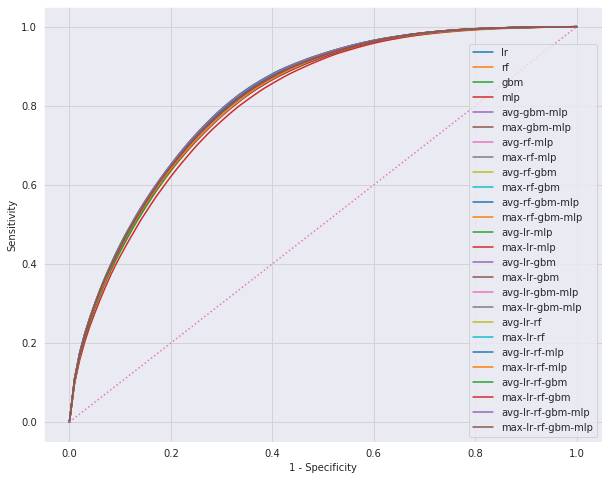

In [9]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(ia_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(legends)
# fig.savefig(args.figdir/'ia_mean_roc.tif', dpi=300)

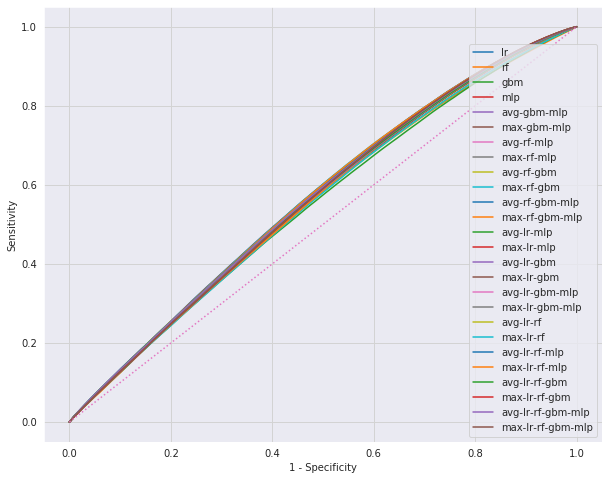

In [10]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(ps_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(legends)
# fig.savefig(args.figdir/'ps_mean_roc.tif', dpi=300)

## Probability Plots

In [ ]:
len(ens_prob[1])

In [ ]:
df = pd.read_csv(args.proc_csv, usecols=args.cols, parse_dates=args.dates)
df['relative_charttime'] = (df['charttime'] - df['intime'])

imminent_df = df.loc[(df['imminent_label'] != -1)][['scispacy_note', 'imminent_label', 'relative_charttime']].reset_index()
discharge_df = df[['scispacy_note', 'discharge_label', 'relative_charttime']].reset_index()

In [ ]:
interval_hours=12
starting_day = -20
ending_day = -1

### Imminent ICU Admission

In [ ]:
model = 'lr'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

model = 'rf'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

model = 'gbm'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_prob(ax[0], imminent_df, 'lr', args.imminent_threshold['lr'], starting_day, ending_day, interval_hours)
plot_prob(ax[1], imminent_df, 'rf', args.imminent_threshold['rf'], starting_day, ending_day, interval_hours)
plot_prob(ax[2], imminent_df, 'gbm', args.imminent_threshold['gbm'], starting_day, ending_day, interval_hours)

fig.text(0.5, 0.08, 'Time to ICU (days)', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', rotation='vertical')

### ICU Discharge

In [ ]:
model = 'lr'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

model = 'rf'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

model = 'gbm'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_prob(ax[0], discharge_df, 'lr', args.discharge_threshold['lr'], starting_day, ending_day, interval_hours)
plot_prob(ax[1], discharge_df, 'rf', args.discharge_threshold['rf'], starting_day, ending_day, interval_hours)
plot_prob(ax[2], discharge_df, 'gbm', args.discharge_threshold['gbm'], starting_day, ending_day, interval_hours)

fig.text(0.5, 0.08, 'Time to ICU (days)', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', rotation='vertical')

## Word Clouds

### Imminent ICU Admission

In [ ]:
scores = {}
feature_names = {}

model = 'lr'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.coef_[0]/clf.coef_[0].sum()

model = 'rf'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

model = 'gbm'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

In [ ]:
model = 'gbm'
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
neg, pos = get_wordcloud(feature_names[model], scores[model], n_words=25)
ax[0].imshow(neg)
ax[0].axis('off')
ax[1].imshow(pos)
ax[1].axis('off')

### ICU Discharge

In [ ]:
scores = {}
feature_names = {}

model = 'lr'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.coef_[0]/clf.coef_[0].sum()

model = 'rf'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

model = 'gbm'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

In [ ]:
model = 'gbm'
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
neg, pos = get_wordcloud(feature_names[model], scores[model], n_words=50)
ax[0].imshow(neg)
ax[0].axis('off')
ax[1].imshow(pos)
ax[1].axis('off')

In [ ]:
# fig.savefig(args.figdir/f'prob.tif', dpi=300)